In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from anndata import AnnData
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [84]:
df_gene = pd.read_csv('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/gencode.vM27.clean.tsv',
                      sep='\t')
dic_map = {x:y for x,y in zip(df_gene['gene_id'], df_gene['gene_name'])}

DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/richter_biorxiv_2020/'
adata_raw = sc.read_h5ad(DATA_PATH+'/raw_data/snRNAseq_mouse_hepatocytes_young_apr21_raw_with_metadata.h5ad')
adata_raw = adata_raw[adata_raw.obs['passing_QC']=='pass'].copy()
adata_raw.obs['n_counts'] = adata_raw.X.sum(axis=1)
adata_raw.obs['n_genes'] = (adata_raw.X>0).sum(axis=1)
sc.pp.filter_genes(adata_raw, min_cells=10)
adata_raw.var_names = [dic_map[x] if x in dic_map else x for x in adata_raw.var_names]
adata_raw.var_names_make_unique()
print('# adata_raw: ', adata_raw.shape)
adata_raw.write(DATA_PATH+'/obj_raw.h5ad')

# adata_raw:  (1649, 24761)


### Processed data

In [91]:
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/richter_biorxiv_2020/'
adata_raw = sc.read_h5ad(DATA_PATH+'/obj_raw.h5ad')

In [95]:
adata_raw.obs

,Sample,Mapped,ERCC,Endogenous,exp.,Experiment,Genome,Strain,ID.Individual,Tissue,...,column,row,percentERCC\n,exon_counts,intron_counts,rrna,inferred_cell_label,passing_QC,n_counts,n_genes
do20279,do20279,121204,93031,56346,SNI-193,CM-SNI-193-1-A,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1,A,0.767557176330814\n,2380.0,9842.0,55.0,B-cells,pass,76155.0,3004
do20282,do20282,339913,299674,80478,SNI-193,CM-SNI-193-1-D,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1,D,0.881619708572488\n,4037.0,15315.0,18.0,Stellate cells,pass,167413.0,1998
do20283,do20283,408637,283364,250546,SNI-193,CM-SNI-193-1-E,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1,E,0.693436962389603\n,23773.0,49474.0,297.0,Hepatocytes,pass,242287.0,3738
do20284,do20284,414308,299961,228694,SNI-193,CM-SNI-193-1-F,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1,F,0.724004846635836\n,17079.0,40443.0,196.0,Hepatocytes,pass,234426.0,3431
do20285,do20285,315340,274343,81994,SNI-193,CM-SNI-193-1-G,Mouse(mm10),C57Bl6/J,18/011303 (SNI-183),Liver,...,1,G,0.869991120695123\n,7932.0,18733.0,208.0,Hepatocytes,pass,162484.0,2404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID-SNI-626-9-D,ID-SNI-626-9-D,394691,63104,663174,SNI-626,ID-SNI-626-9-D,Mouse(mm10),C57Bl6/J,16/036335,Liver,...,9,D,0.15988203430025\n,9018.0,51508.0,160.0,B-cells,pass,139059.0,2620
ID-SNI-626-9-E,ID-SNI-626-9-E,270410,60893,419034,SNI-626,ID-SNI-626-9-E,Mouse(mm10),C57Bl6/J,16/036335,Liver,...,9,E,0.225187677970489\n,24800.0,39448.0,630.0,Hepatocytes,pass,109697.0,3743
ID-SNI-626-9-F,ID-SNI-626-9-F,258474,218300,80348,SNI-626,ID-SNI-626-9-F,Mouse(mm10),C57Bl6/J,16/036335,Liver,...,9,F,0.844572374784311\n,8138.0,3827.0,2082.0,Hepatobiliary cells,pass,61603.0,1471
ID-SNI-626-9-G,ID-SNI-626-9-G,312279,79482,465594,SNI-626,ID-SNI-626-9-G,Mouse(mm10),C57Bl6/J,16/036335,Liver,...,9,G,0.254522398240035\n,26316.0,49233.0,707.0,Hepatocytes,pass,122255.0,3937


In [94]:
set(adata_raw.obs['Sample'])

{'do19630',
 'do22937',
 'do19851',
 'ID-SNI-634-6-E',
 'ID-SNI-635-7-A',
 'ID-SNI-626-18-E',
 'do19623',
 'do19852',
 'ID-SNI-635-16-F',
 'do19672',
 'do22855',
 'do21013',
 'do20157',
 'do23288',
 'ID-SNI-626-16-G',
 'ID-SNI-635-18-H',
 'ID-SNI-626-14-H',
 'ID-SNI-635-6-A',
 'do20888',
 'do20815',
 'do20807',
 'do19837',
 'ID-SNI-635-17-B',
 'do20781',
 'do20631',
 'do20062',
 'do19736',
 'do20764',
 'do20858',
 'do23111',
 'do23273',
 'do20472',
 'do20330',
 'do20504',
 'ID-SNI-634-10-E',
 'do20340',
 'ID-SNI-634-6-H',
 'do20742',
 'do23415',
 'ID-SNI-634-5-C',
 'do20647',
 'ID-SNI-635-10-D',
 'do20300',
 'do21025',
 'do22954',
 'do23324',
 'do20630',
 'do20683',
 'ID-SNI-635-4-G',
 'do20785',
 'do23240',
 'do20158',
 'do21006',
 'do19833',
 'do20541',
 'do20887',
 'do20843',
 'ID-SNI-634-8-B',
 'do20415',
 'do20681',
 'do19945',
 'do23338',
 'do20535',
 'ID-SNI-626-14-C',
 'do19547',
 'ID-SNI-626-12-F',
 'do20173',
 'do23323',
 'do20527',
 'do20336',
 'do20043',
 'do20962',
 'ID-SN

In [96]:
# Make .cov file 
df_cov = pd.DataFrame(index=adata_raw.obs.index)
# df_cov['const'] = 1
# df_cov['n_genes'] = (adata_raw.X>0).sum(axis=1)
for mouse in set(adata_raw.obs['ID.Individual']):
    df_cov[mouse] = (adata_raw.obs['ID.Individual']==mouse)*1
df_cov.to_csv(DATA_PATH+'/richter_biorxiv_2020.cov', sep='\t')

In [88]:
# Cluster the data to have UMAP plot 
adata = adata_raw.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
print(adata.shape)

sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                            min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
sc.pp.scale(adata, max_value=10, zero_center=False)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)
sc.tl.louvain(adata, resolution = 0.8)
sc.tl.leiden(adata, resolution = 0.8)
sc.tl.umap(adata)
adata.write(DATA_PATH+'/obj_processed.h5ad')

(1649, 24761)


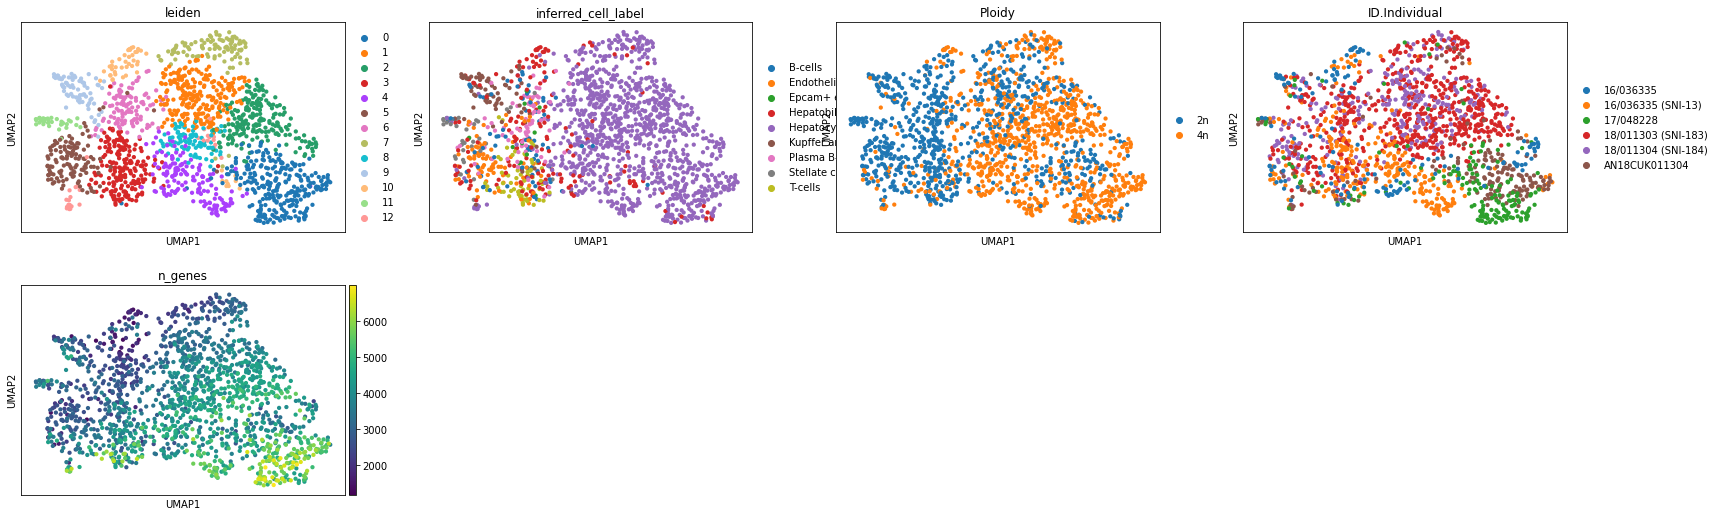

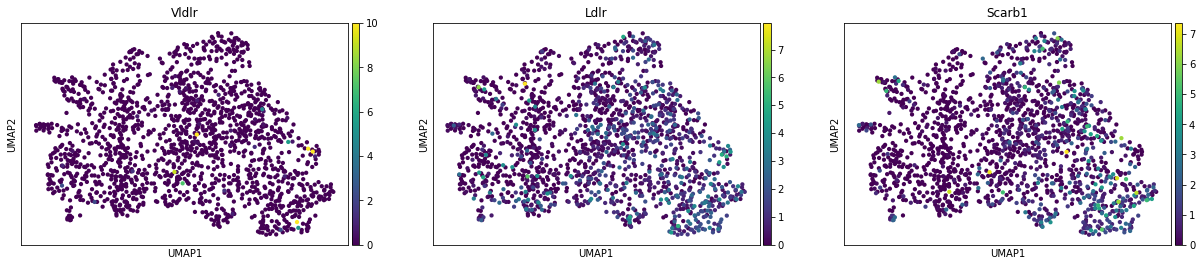

In [89]:
sc.pl.umap(adata, color=['leiden', 'inferred_cell_label', 'Ploidy',  'ID.Individual', 'n_genes'])
sc.pl.umap(adata, color=['Vldlr', 'Ldlr', 'Scarb1'])